In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150

## summary

- ffn: 两层的 MLP
    - 两个细节
        - h => 4h => h
            - 768 => 3072 => 768
        - Gelu
- 模型的 capacity 以及 memorization (world knowledge)
- Layer Normalization & skip connections
    - LN 在整个模型拓扑结构中的位置

## review multihead attention

In [2]:
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
# print(model)
# print(model.embeddings)
# print(model.encoder)
# 只显示了 layer 的定义，层与层之间的拓扑/连接关系，在 module 的 forward 中定义；
print(model.encoder.layer[0])
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained(model_ckpt)
config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [3]:
# batch_size, seq_len, hidden_size, (b, s, h)
# 经过 W_q, W_k, W_v 的 project 之后得到 query, key, value
def scaled_dot_product_attention(query, key, value):
    # hidden_size
    dim_k = key.size(-1)
    # batch_size, seq_len, seq_len
    attn_scores = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(dim_k)
    attn_weights = F.softmax(attn_scores, dim=-1)
    return torch.bmm(attn_weights, value)

In [4]:
class AttentionHead(nn.Module):
    # head_dim: 768/12 == 64
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        # learnable parameters
        self.Wq = nn.Linear(embed_dim, head_dim)
        self.Wk = nn.Linear(embed_dim, head_dim)
        self.Wv = nn.Linear(embed_dim, head_dim)
    def forward(self, hidden_states):
        # project
        q = self.Wq(hidden_states)
        # project
        k = self.Wk(hidden_states)
        # project
        v = self.Wv(hidden_states)
        attn_outputs = scaled_dot_product_attention(q, k, v)
        return attn_outputs

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        # 768/12 == 64
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([
            AttentionHead(embed_dim, head_dim) for _ in range(num_heads)
        ])
        # 768 => 768
        self.output_layer = nn.Linear(embed_dim, embed_dim)
    def forward(self, hidden_state):
        print(f'input hidden_state: {hidden_state.shape}')
        print(f'head(hidden_state): {self.heads[11](hidden_state).shape}')
        x = torch.cat([head(hidden_state) for head in self.heads], dim=-1)
        print(f'cat heads: {x.shape}')
        x = self.output_layer(x)
        return x

In [7]:
mha = MultiHeadAttention(config)

In [8]:
# input
# config.vocab_size: 30522, 
# config.hidden_size: 768=64*12
# lookup-table, learnable
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
# token_embedding
sample_text = 'time flies like an arrow'
model_inputs = tokenizer(sample_text, return_tensors='pt', add_special_tokens=False)
# forward of embedding module
input_embeddings = token_embedding(model_inputs['input_ids'])
# batch_size, seq_len, hidden_size
input_embeddings.shape

torch.Size([1, 5, 768])

In [9]:
attn_output = mha(input_embeddings)

input hidden_state: torch.Size([1, 5, 768])
head(hidden_state): torch.Size([1, 5, 64])
cat heads: torch.Size([1, 5, 768])


## FFN

- RELU: $x\mathbf{1}_{x>0}$ （分段线性函数）
- GELU: $x\Phi\left(x\right)$
    - https://paperswithcode.com/method/gelu

$$
\Phi(x) = \frac{1 + \text{Erf}(x/\sqrt{2})}{2}.
$$

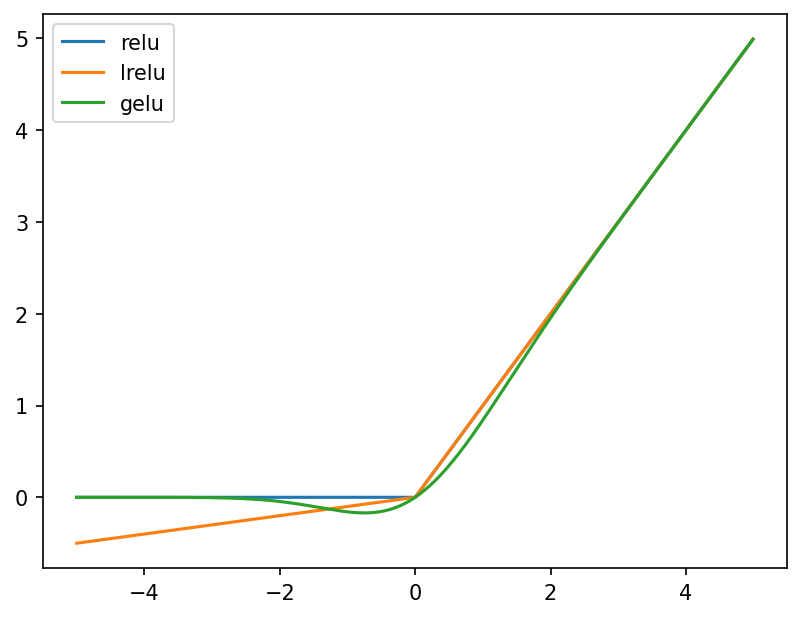

In [10]:
x = np.arange(-5, 5, 0.01)
plt.plot(x, nn.ReLU()(torch.from_numpy(x)))
plt.plot(x, nn.LeakyReLU(negative_slope=0.1)(torch.from_numpy(x)))
plt.plot(x, nn.GELU()(torch.from_numpy(x)))
plt.legend(['relu', 'lrelu', 'gelu'])

In [11]:
class FeedFoward(nn.Module):
    def __init__(self, config):
        super().__init__()
        # config.intermediate_size: 4*h == 4*768 == 3072
        # (intermediate)
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        # (output)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    def forward(self, x):
        # b, s, h => b, s, 4h
        x = self.fc1(x)
        x = self.gelu(x)
        # b, s, 4h => b, s, h
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [12]:
ffn = FeedFoward(config)

In [13]:
ffn(attn_output).size()

torch.Size([1, 5, 768])

## layer norm && skip connection

- layer norm（`config, "layer_norm_eps": 1e-12,`）
    - zero mean & one variance
    - 与 batch norm 相对，是样本层面
    - 对与 nlp 问题，一般是每一个 token 对应的 embedding （也就是 768 维 的 hidden state 进行 0 均值 1 标准差的归一化）
- 在 transformers 中主要是两处用到了 layer norm
    - embedding
        - 对于最终的 token_embedding
    - 构建 bert layer（或者叫 transformer encoder layer）

### layer norm 在 bert layer （TransformerEncoderLayer）中的位置

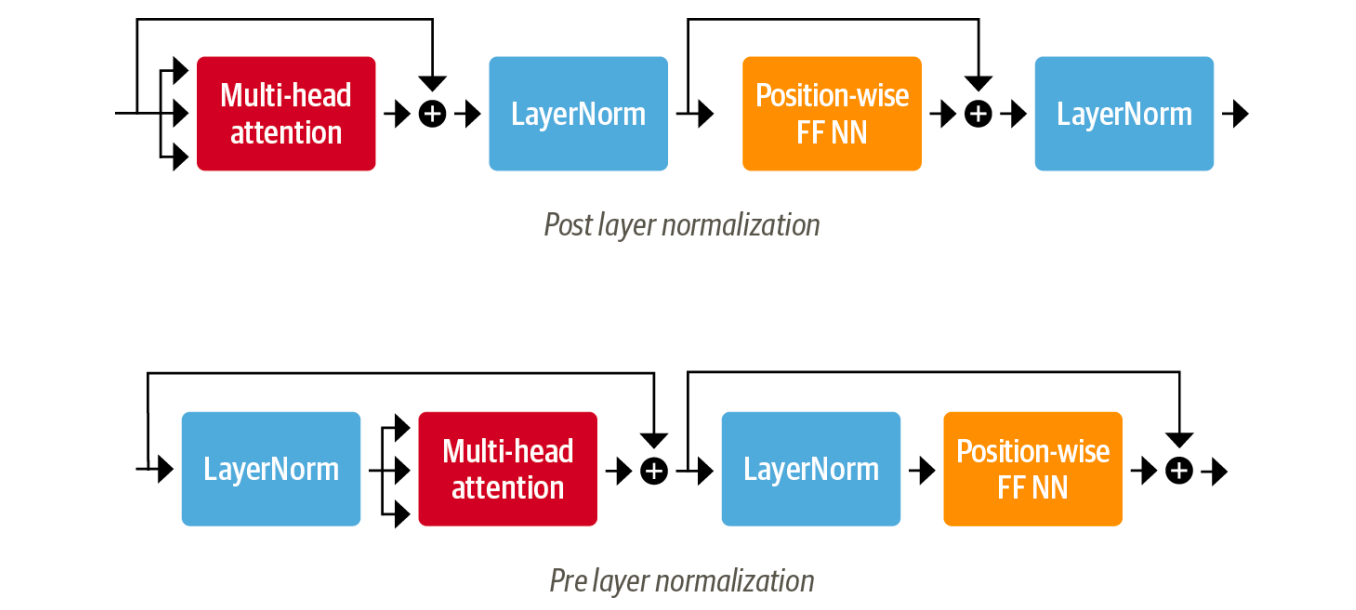

In [17]:
Image('../imgs/layer_norm_pos.png', width=600)

- Post layer normalization（huggingface 默认实现）
- Pre layer normalization
- post/pre 针对的是 multiheadattn 

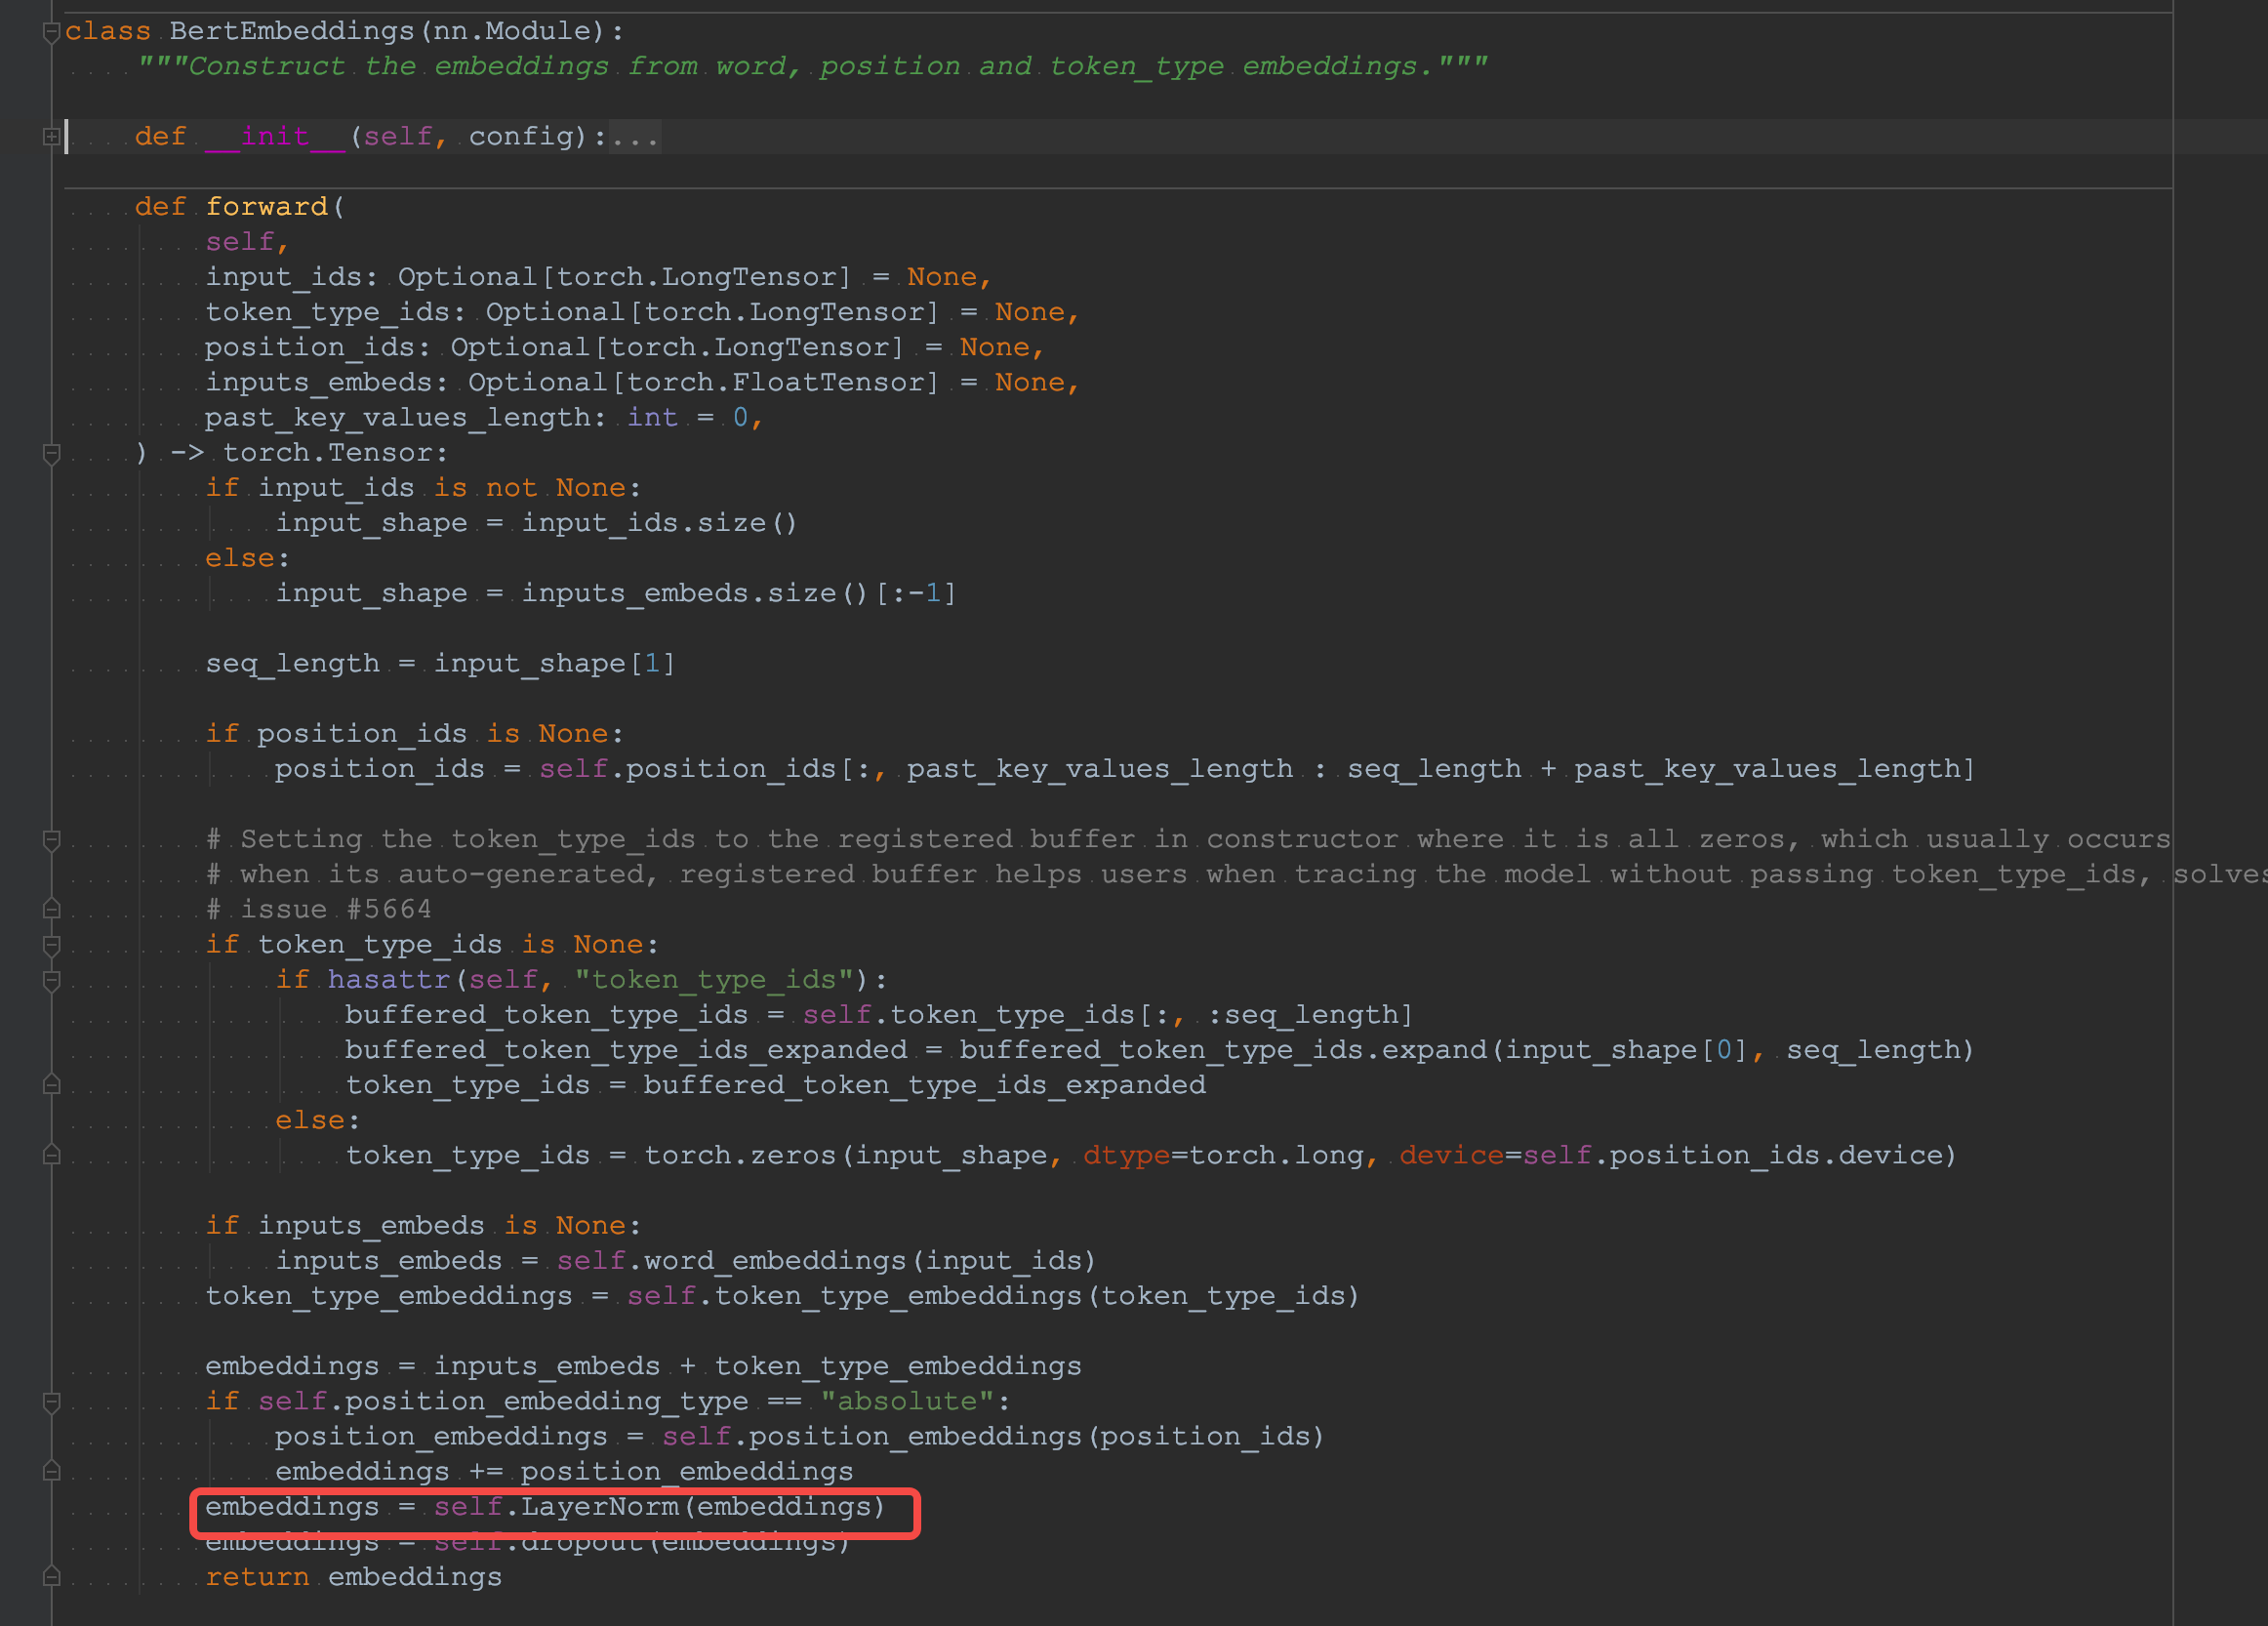

In [14]:
Image('../imgs/LN1.png', width=600)

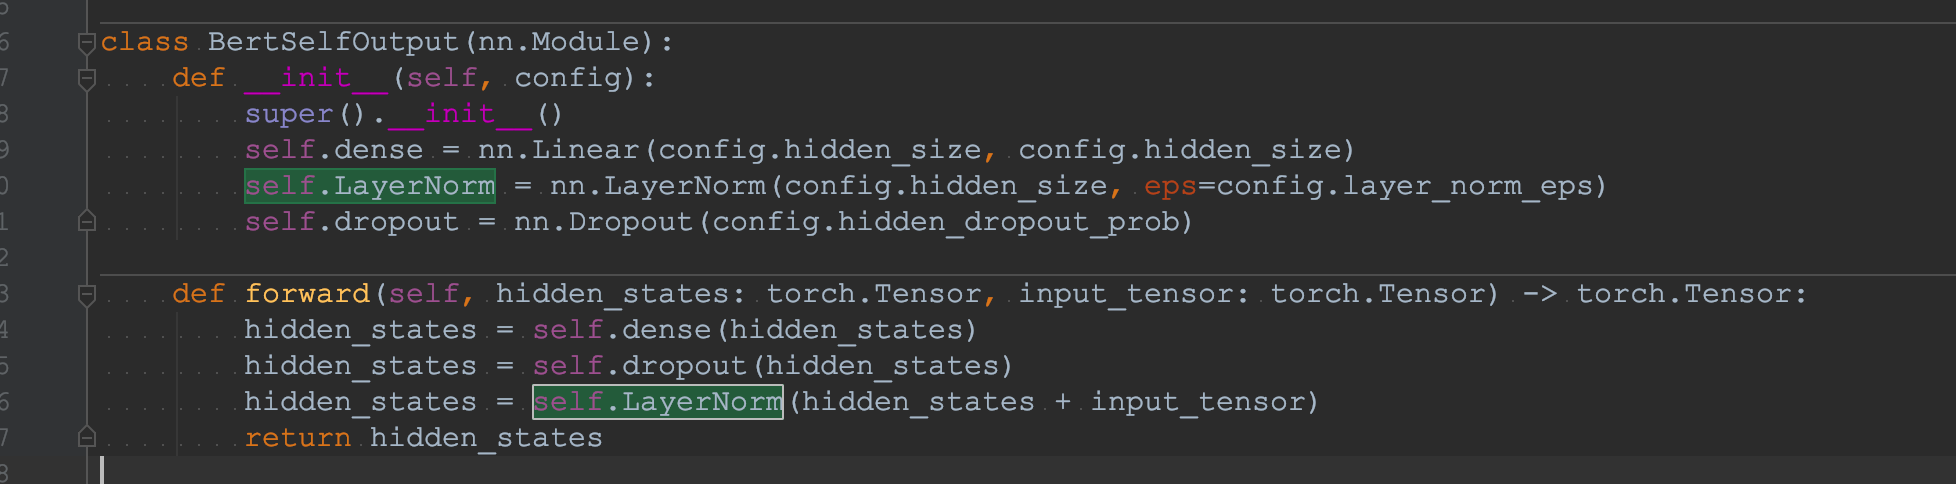

In [15]:
Image('../imgs/LN3.png', width=600)

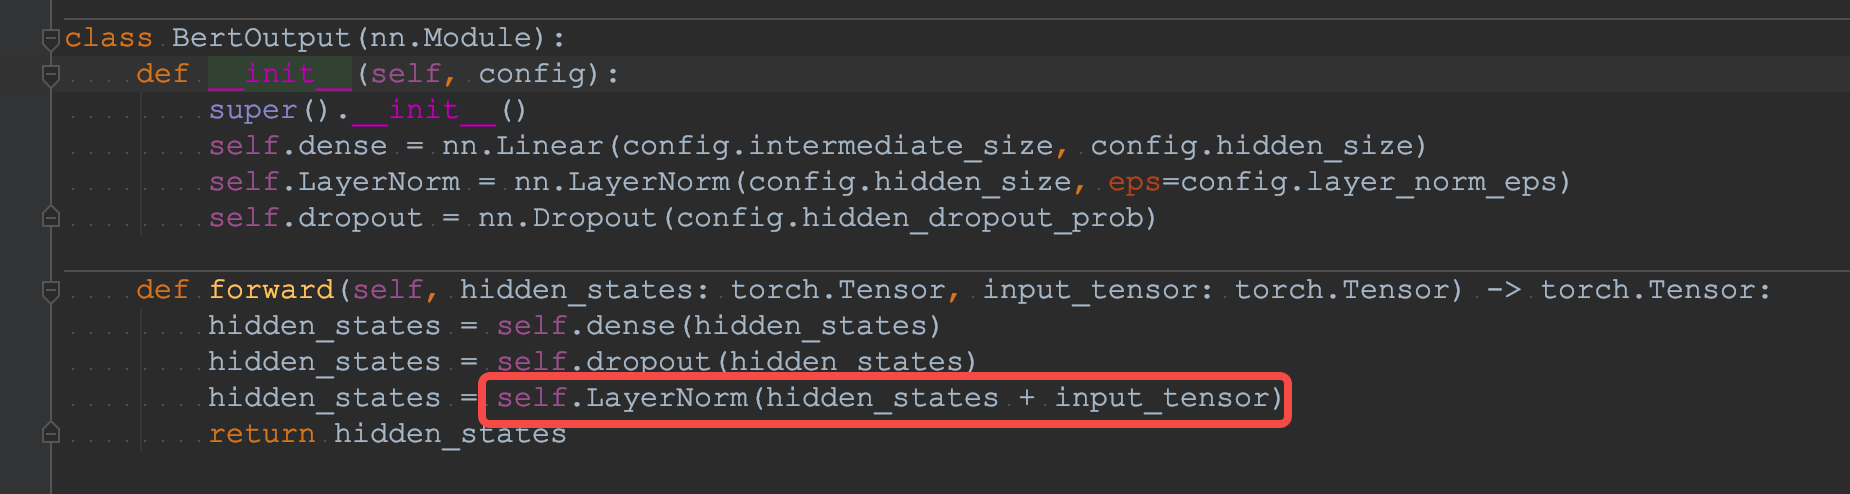

In [16]:
Image('../imgs/LN2.png', width=600)

## EncoderLayer

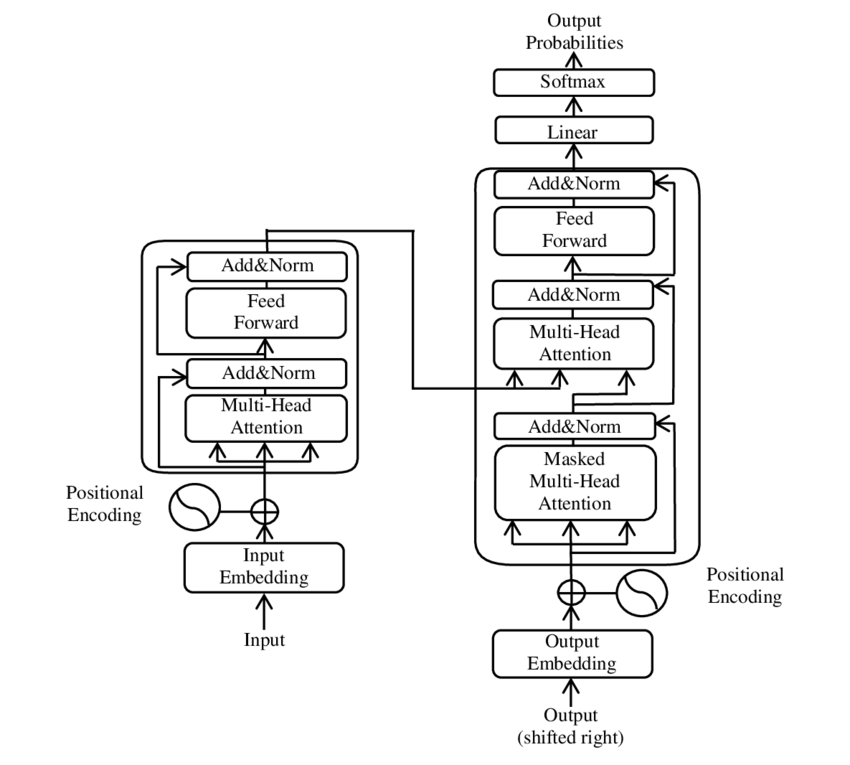

In [18]:
Image('../imgs/The-Transformer-model-architecture.png')

In [19]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 768, embedding 级别进行 0均值 1 标准差的归一化处理
        self.ln1 = nn.LayerNorm(config.hidden_size)
        # 768, embedding 级别进行 0均值 1 标准差的归一化处理
        self.ln2 = nn.LayerNorm(config.hidden_size)
        self.attn = MultiHeadAttention(config)
        self.ffn = FeedFoward(config)
    def forward(self, x):
        # x from embedding, (b, s, h)
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        # (b, s, h)
        return x

In [20]:
encoder_layer = TransformerEncoderLayer(config)

In [21]:
encoder_layer(input_embeddings).shape

input hidden_state: torch.Size([1, 5, 768])
head(hidden_state): torch.Size([1, 5, 64])
cat heads: torch.Size([1, 5, 768])


torch.Size([1, 5, 768])